# Feature Engineering for Eredivisie Match Prediction

This notebook focuses on the **Feature Engineering** phase of the football match prediction project. The goal of this project is to predict the outcome of football matches, specifically whether the result will be a **home win**, **draw**, or **away win**.

In this notebook, we will:

- Calculate the **dependent variable** (`home_win`, `draw`, `away_win`) based on historical match data.
- Engineer and prepare the **features** required for the predictive model.
    - `elo_rating`: Based on the methodology of ELO in chess we can calculate a rating per team that reflects the level of a certain team compared to the competition. For notation on the formula's used see: https://en.wikipedia.org/wiki/Elo_rating_system 
    - `elo_difference`: The difference in ELO rating between the opposing teams (reasoned from the `home_team`).
    - `form`: ....

This step is crucial as it transforms raw data into meaningful inputs that enhance the model's performance.

**Future:** N/A

**Version:** 1.0


In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter

## Functions:

In [2]:
def create_match_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create match results from the dataframe.

    Returns: a DataFrame with two new columns:
        - 'match_result': 'home_win', 'away_win', or 'draw'
        - 'match_result_numeric': 1 for home win, -1 for away win, and 0 for draw.
    """
    # Create a new column 'match_result' based on the conditions
    df['match_result'] = np.where(df['home_score'] > df['away_score'], 'home_win',
                                   np.where(df['home_score'] < df['away_score'], 'away_win', 'draw'))

    # Create a new column 'match_result_numeric' based on the conditions
    df['match_result_numeric'] = np.where(df['home_score'] > df['away_score'], 1,
                                          np.where(df['home_score'] < df['away_score'], -1, 0))
    
    return df

In [3]:
def create_elo_rating(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create Elo ratings for teams based on match results. 
    See: https://mattmazzola.medium.com/implementing-the-elo-rating-system-a085f178e065 
    for details on Elo rating calculation.

    Returns: a DataFrame with two new columns:
        - 'home_elo': Elo rating for the home team
        - 'away_elo': Elo rating for the away team
    """
    # Initialize Elo ratings for teams
    elo_ratings = {}

    # Create constants for Elo rating calculation
    initial_elo = 1000      # Initial Elo rating for all teams
    k_factor = 32           # K-factor for Elo rating calculation
    scale_factor = 400      # Scale factor for Elo rating calculation

    # Create new columns initialized with None
    df['home_elo'] = None
    df['away_elo'] = None

    for index, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_score = row['home_score']
        away_score = row['away_score']

        # Initialize Elo ratings for teams if not already present
        if home_team not in elo_ratings:
            elo_ratings[home_team] = initial_elo
        if away_team not in elo_ratings:
            elo_ratings[away_team] = initial_elo

        # Get current Elo ratings for teams (before updating)
        home_elo = elo_ratings[home_team]
        away_elo = elo_ratings[away_team]

        # Store the current Elo ratings in the DataFrame
        df.at[index, 'home_elo'] = home_elo
        df.at[index, 'away_elo'] = away_elo

        # Calculate expected probability of winning for home and away teams
        expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / scale_factor))
        expected_away = 1 / (1 + 10 ** ((home_elo - away_elo) / scale_factor))

        # Calculate actual score for home and away teams
        if home_score > away_score:
            actual_home = 1
            actual_away = 0
        elif home_score < away_score:
            actual_home = 0
            actual_away = 1
        else:
            actual_home = 0.5
            actual_away = 0.5

        # Update Elo ratings for home and away teams (for future matches)
        elo_ratings[home_team] += k_factor * (actual_home - expected_home)
        elo_ratings[away_team] += k_factor * (actual_away - expected_away)

    return df

## Analysis:

In [4]:
# Import the data
df_eredivisie_results = pd.read_csv('../Files/eredivisie_results_cleaned.csv')

df_eredivisie_results.head(10)

,season,date,home_team,away_team,home_score,away_score
0,1956-1957,1956-09-02,Ajax,NAC Breda,1,0
1,1956-1957,1956-09-02,BVV Den Bosch,Elinkwijk,1,2
2,1956-1957,1956-09-02,DOS,Sparta Rotterdam,2,3
3,1956-1957,1956-09-02,Fortuna Sittard,Eindhoven,4,1
4,1956-1957,1956-09-02,NOAD,BVC Amsterdam,1,3
5,1956-1957,1956-09-02,PSV,MVV,1,3
6,1956-1957,1956-09-02,SC Enschede,Roda JC,5,2
7,1956-1957,1956-09-02,VVV-Venlo,GVAV,1,0
8,1956-1957,1956-09-02,Willem II,Feyenoord,3,3
9,1956-1957,1956-09-09,BVC Amsterdam,Willem II,0,6


In [5]:
# Create the match result columns
df_eredivisie_results = create_match_results(df_eredivisie_results)

df_eredivisie_results.head(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric
0,1956-1957,1956-09-02,Ajax,NAC Breda,1,0,home_win,1
1,1956-1957,1956-09-02,BVV Den Bosch,Elinkwijk,1,2,away_win,-1
2,1956-1957,1956-09-02,DOS,Sparta Rotterdam,2,3,away_win,-1
3,1956-1957,1956-09-02,Fortuna Sittard,Eindhoven,4,1,home_win,1
4,1956-1957,1956-09-02,NOAD,BVC Amsterdam,1,3,away_win,-1
5,1956-1957,1956-09-02,PSV,MVV,1,3,away_win,-1
6,1956-1957,1956-09-02,SC Enschede,Roda JC,5,2,home_win,1
7,1956-1957,1956-09-02,VVV-Venlo,GVAV,1,0,home_win,1
8,1956-1957,1956-09-02,Willem II,Feyenoord,3,3,draw,0
9,1956-1957,1956-09-09,BVC Amsterdam,Willem II,0,6,away_win,-1


In [6]:
# Create the Elo ratings
df_eredivisie_results = create_elo_rating(df_eredivisie_results)

df_eredivisie_results[df_eredivisie_results['home_elo'] == max(df_eredivisie_results['home_elo'])]

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo
20552,2024-2025,2024-10-26,PSV,PEC Zwolle,6,0,home_win,1,1464.200509,1017.212448


In [24]:
# Melt the dataframe to combine home and away Elo ratings
df_elo_melted = df_eredivisie_results.melt(id_vars=['date', 'home_team', 'away_team', 'season'], 
                                             value_vars=['home_elo', 'away_elo'], 
                                             var_name='team_type', 
                                             value_name='elo_rating')

# Sort the values by date
df_elo_melted = df_elo_melted.sort_values(by='date').reset_index(drop=True)

# Assign the correct team name to each row
df_elo_melted['team'] = df_elo_melted.apply(
    lambda x: x['home_team'] if x['team_type'] == 'home_elo' else x['away_team'],
    axis=1
)

# Drop unnecessary columns
df_elo_melted = df_elo_melted.drop(columns=['home_team', 'away_team', 'team_type'])

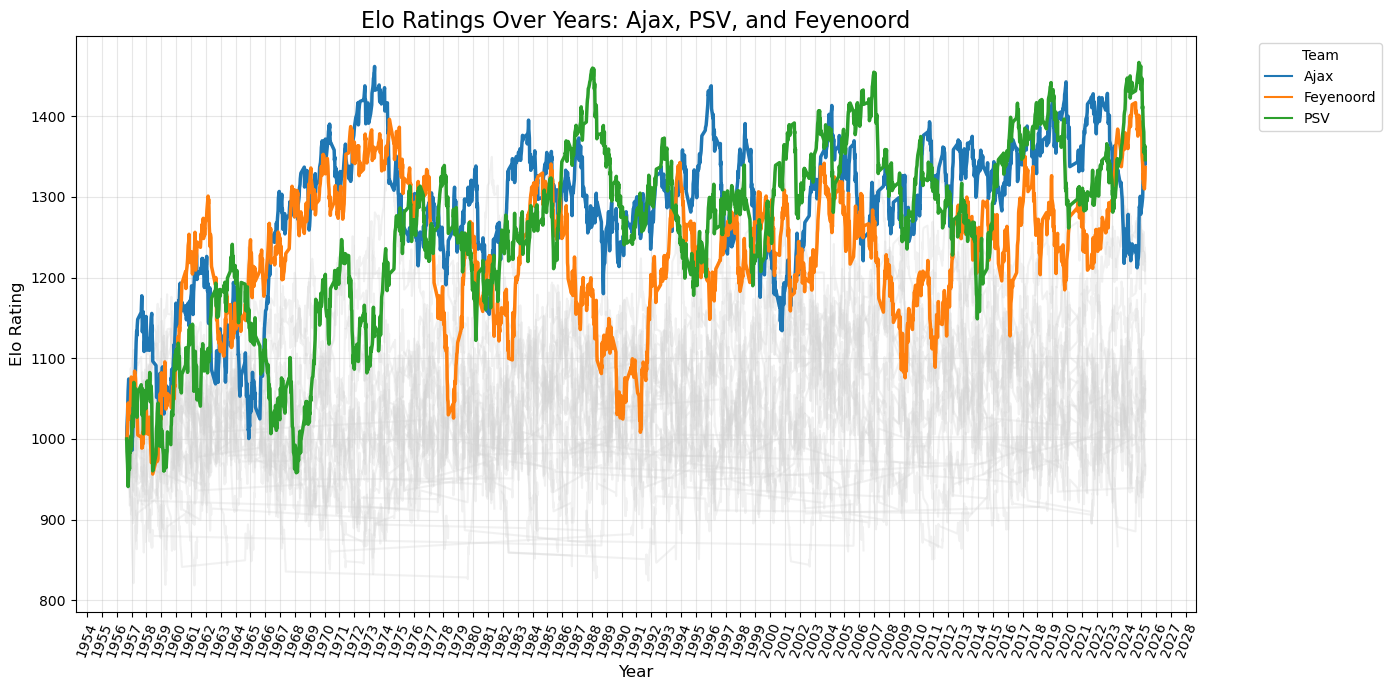

In [25]:
# Ensure 'date' is datetime
df_elo_melted['date'] = pd.to_datetime(df_elo_melted['date'])

# Filter for highlighted teams
highlight_teams = ['Ajax', 'PSV', 'Feyenoord']
df_highlight = df_elo_melted[df_elo_melted['team'].isin(highlight_teams)]
df_other = df_elo_melted[~df_elo_melted['team'].isin(highlight_teams)]

# Create plot
plt.figure(figsize=(14, 7))

# Plot other teams (faint background)
sns.lineplot(
    data=df_other,
    x='date',  # Use actual datetime values
    y='elo_rating',
    hue='team',
    palette=['lightgray'] * len(df_other['team'].unique()),
    alpha=0.3,
    legend=False
)

# Plot highlighted teams
sns.lineplot(
    data=df_highlight,
    x='date',
    y='elo_rating',
    hue='team',
    linewidth=2.5,
    estimator=None
)

# Configure x-axis to show years
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())  # Tick every year
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format as just year

plt.title('Elo Ratings Over Years: Ajax, PSV, and Feyenoord', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Elo Rating', fontsize=12)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()